## LangGraph Fundamentals - Flow Engineering and Finite State Machine

What is LangGraph?
LangGraph is a low-level orchestration framework for building stateful, 
multi-agent applications. Think of it as a way to create workflows where 
each step (node) processes data and passes it to the next step.

Key Concepts:
1. State: Shared memory that all nodes can read from and write to
2. Nodes: Functions that do specific tasks (like process data)
3. Edges: Connections between nodes that define the flow

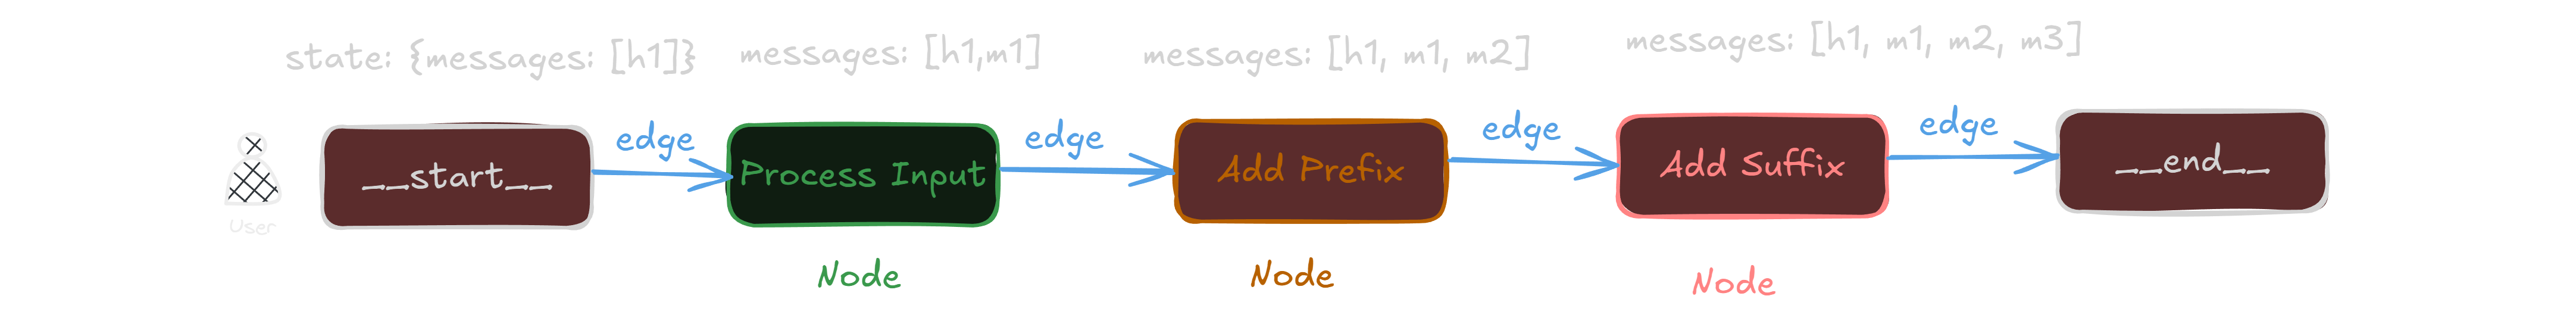

In [1]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

In [2]:
class SimpleState(TypedDict):
    input_text: str
    output_text: str

In [7]:
SimpleState(input_text="hello", output_text="HELLO")

{'input_text': 'hello', 'output_text': 'HELLO'}

#### Custom Node

In [8]:
def process_input(state: SimpleState) -> SimpleState:
    output_text = state['input_text'].upper()

    return {'output_text': output_text}

In [9]:
state = {'input_text': 'hello', 'output_text': ''}
process_input(state)

{'output_text': 'HELLO'}

In [ ]:
# state = {'input_text': 'hello', 'output_text': 'HELLO'}

In [17]:
def add_prefix(state:SimpleState):
    print("Current State [Prefix]", state)

    output = "Hey, i have added something here. " + state['output_text']

    return {'output_text': output}

In [18]:
add_prefix(process_input(state))

Current State [Prefix] {'output_text': 'HELLO'}


{'output_text': 'Hey, i have added something here. HELLO'}

In [19]:
def add_suffix(state:SimpleState):

    print("Current State [Suffix]", state)

    output = state["output_text"] + ". i have added suffix!"

    return {'output_text': output}


In [20]:
add_suffix(add_prefix(process_input(state)))

Current State [Prefix] {'output_text': 'HELLO'}
Current State [Suffix] {'output_text': 'Hey, i have added something here. HELLO'}


{'output_text': 'Hey, i have added something here. HELLO. i have added suffix!'}

In [ ]:
def create_simple_graph():
    builder = StateGraph(SimpleState)

    # add the nodes
    builder.add_node("process_input", process_input)
    builder.add_node("add_prefix", add_prefix)
    builder.add_node("add_suffix", add_suffix)

    # connect the edges
    builder.add_edge(START, "process_input")
    builder.add_edge("process_input", "add_prefix")
    builder.add_edge("add_prefix", "add_suffix")
    builder.add_edge("add_suffix", END)

    # make it langchain runnable
    graph = builder.compile()

    return graph


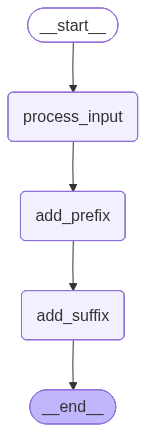

In [22]:
graph = create_simple_graph()
graph

In [23]:
# initial_state or user input

initial_state= {'input_text': "hello"}

graph.invoke(initial_state)

Current State [Prefix] {'input_text': 'hello', 'output_text': 'HELLO'}
Current State [Suffix] {'input_text': 'hello', 'output_text': 'Hey, i have added something here. HELLO'}


{'input_text': 'hello',
 'output_text': 'Hey, i have added something here. HELLO. i have added suffix!'}

In [24]:

initial_state= {'input_text': "hello", "some_other_state": 'hi'}

graph.invoke(initial_state)

Current State [Prefix] {'input_text': 'hello', 'output_text': 'HELLO'}
Current State [Suffix] {'input_text': 'hello', 'output_text': 'Hey, i have added something here. HELLO'}


{'input_text': 'hello',
 'output_text': 'Hey, i have added something here. HELLO. i have added suffix!'}

In [25]:

initial_state= {'input_text': "hello", "output_text": 'hi'}

graph.invoke(initial_state)

Current State [Prefix] {'input_text': 'hello', 'output_text': 'HELLO'}
Current State [Suffix] {'input_text': 'hello', 'output_text': 'Hey, i have added something here. HELLO'}


{'input_text': 'hello',
 'output_text': 'Hey, i have added something here. HELLO. i have added suffix!'}